<a href="https://colab.research.google.com/github/croco22/CapstoneProjectTDS/blob/main/notebooks/02_Dataset_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2: Dataset Evaluation
In this chapter, we conduct the evaluation using Q&A models. We assess and fine-tune various models from Hugging Face by applying different metrics from the literature to measure their performance. This includes evaluating their accuracy, precision, recall, and other relevant benchmarks to determine their effectiveness in answering questions. Additionally, we compare the performance of different models before and after fine-tuning to analyze the impact of our adjustments and improvements.

## Imports and Setup

In [1]:
%%capture
!pip install datasets
!pip install dateparser
!pip install fuzzywuzzy
!pip install word2number

import re
from datetime import datetime

import dateparser
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datasets import Dataset
from fuzzywuzzy import fuzz
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    jaccard_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from transformers import (
    AutoModelForQuestionAnswering,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    pipeline,
)
from word2number import w2n

In [2]:
url = 'https://raw.githubusercontent.com/croco22/CapstoneProjectTDS/refs/heads/main/qa_dataset.json'
data = pd.read_json(url)

data.head()

,type,question,options,intended_answer,context,timestamp
0,SINGLE_SELECT,Data processing consent,"[Yes, No]",Yes,"Absolutely, you've got my consent for that dat...",2025-01-29 13:37:12.404
1,SINGLE_SELECT,Data processing consent,"[Yes, No]",Yes,"Yes, you can absolutely process my data, that'...",2025-01-29 13:37:12.404
2,SINGLE_SELECT,Data processing consent,"[Yes, No]",Yes,"Without any hesitation, I can confirm yes, tha...",2025-01-29 13:37:12.404
3,SINGLE_SELECT,Data processing consent,"[Yes, No]",Yes,"Okay then, for that question regarding data pr...",2025-01-29 13:37:12.404
4,SINGLE_SELECT,Data processing consent,"[Yes, No]",Yes,"That sounds perfectly fine to me, I wholeheart...",2025-01-29 13:37:12.404


## Auxilary Functions
*   Function to convert number words into actual numbers, e.g. "fifty-one" ➡ 51
*   Function to check if options appear explicitly in text
*   Function to calculate metrics
*   Function to visualize metrics


In [3]:
def convert_numbers_in_text(text):
    # Regular expression to find number words contained in questionnaires
    pattern = r'(two thousand|two hundred one|two hundred|fifty-one|thirty-one|twenty-one|sixteen|fifteen|eleven|thirty|twenty|fifty|forty|sixty|ten|five|six|one)'
    # Interesting finding: Regex only works if longer words are in order before shorter that contain similar parts, e.g. fifty-one has to be in front of fifty to work as intended

    def convert(match):
        word = match.group(0)
        try:
            # Convert the word to number
            return str(w2n.word_to_num(word))
        except ValueError:
            return word

    # Replace all number words in the text with their integer equivalents
    converted_text = re.sub(pattern, convert, text, flags=re.IGNORECASE)

    # Now convert ranges like 'twenty to thirty' into '20-30'
    converted_text = re.sub(r'(\d+)\s*(to|and)\s*(\d+)', r'\1-\3', converted_text)

    # Replace text
    converted_text = converted_text.replace('more than 2000', 'larger than 2000')
    converted_text = converted_text.replace('More than 2000', 'Larger than 2000')

    return converted_text


def is_exact_or_phrase_match(option, text):
    # Escape the option to handle special characters
    escaped_option = re.escape(option.strip())

    # Pattern to match the option as a full word or part of a phrase
    pattern = rf'\b(?:\w+\s+)*{escaped_option}(?:\s+\w+)*\b'

    # Search for the pattern in the text (case-insensitive)
    return re.search(pattern, text, re.IGNORECASE) is not None


def calculate_metrics(y_true, y_pred, multi_true=None, multi_pred=None):
    if not y_true:  # ensure y_true is not empty to avoid errors
        return {"Accuracy": 0, "Precision": 0, "Recall": 0, "F1 Score": 0, "Jaccard Score": 0}

    if multi_true and multi_pred:
        jaccard_scores = []
        for yt, yp in zip(multi_true, multi_pred):
            intersection = len(yt & yp)
            union = len(yt | yp)
            jaccard_score = intersection / union if union != 0 else 0
            jaccard_scores.append(jaccard_score)
        jaccard = sum(jaccard_scores) / len(jaccard_scores) if jaccard_scores else 0
    else:
        jaccard = 0

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1 Score": f1_score(y_true, y_pred, zero_division=0),
        "Jaccard Score": jaccard,
    }


def plot_metrics(metrics_per_type, overall_metrics):
    metric_names = ["Accuracy", "Precision", "Recall", "F1 Score", "Jaccard Score"]
    plt.figure(figsize=(8, 5))
    df_heatmap = pd.DataFrame(metrics_per_type).T
    sns.heatmap(df_heatmap, annot=True, cmap="coolwarm", linewidths=0.5, vmin=0, vmax=1)
    plt.title("Metrics per question type")
    plt.show()

## Generate QA Pipelines

**Models:**
*   deepset/roberta-base-squad2
*   distilbert-base-cased-distilled-squad
*   google-bert/bert-large-uncased-whole-word-masking-finetuned-squad

**Parameters:**
*   *topk (int, optional, defaults to 1)* – The number of answers to return (will be
chosen by order of likelihood).




In [4]:
qa_pipeline1 = pipeline("question-answering", model="deepset/roberta-base-squad2")
qa_pipeline2 = pipeline("question-answering", model='distilbert-base-cased-distilled-squad')
qa_pipeline3 = pipeline("question-answering", model='google-bert/bert-large-uncased-whole-word-masking-finetuned-squad')

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
# topk>1 to extract multiple answers from context
qa_pipeline_ms = pipeline("question-answering", model="deepset/roberta-base-squad2", top_k=10)

## Predict Function
Function to extract answers to given questions from a given context for different question types.

In [6]:
def predict_answers(df, qa_pipeline):
    metrics_per_type = dict()

    type_metrics = {
        t: {"y_true": [], "y_pred": []} for t in ["SINGLE_SELECT", "DATE", "NUMBER"]
    }
    type_metrics["MULTI_SELECT"] = {
        "y_true": [],
        "y_pred": [],
        "multi_true": [],
        "multi_pred": []
    }

    for _, row in df.iterrows():
        predictions = list()
        is_correct = False

        if (row['type'] == "SINGLE_SELECT") or (row['type'] == "MULTI_SELECT"):
            if row['options']:
                converted_context = convert_numbers_in_text(row['context'])
            # Extract answers from context (topk > 1)
            results = qa_pipeline_ms(question=row['question'], context=converted_context)

            if isinstance(results, dict):
                # Convert to list if a single object is found
                results = [results]
            elif not isinstance(results, list):
                continue

            # Check answer for similarity with given answer options
            for result in results:
                extracted_answer = result.get('answer', '')
                for option in row['options']:
                    similarity_score = fuzz.ratio(extracted_answer.lower(), option.lower())
                    if similarity_score >= 60:  # Threshold for similarity
                        predictions.append((option, result.get('score', 0)))

        if row['type'] == "SINGLE_SELECT":
            # Select prediction with highest confidence
            if predictions:
                predicted_option, confidence = max(predictions, key=lambda x: x[1])
                is_correct = predicted_option == row['intended_answer']
            else:
                predicted_option = None

        if row['type'] == "MULTI_SELECT":
            if predictions:
                # Select all answers that matched an option
                predicted_option = []
                for option, score in predictions:
                    if option not in predicted_option:
                        predicted_option.append(option)
                is_correct = set(predicted_option) == set(row['intended_answer'])
            else:
                predicted_option = None

        if row['type'] == "DATE":
            try:
                # Base timestamp from dataframe column (Unix-Timestamp)
                base_timestamp = pd.Timestamp(row['timestamp'], unit='ms')

                # Extract time expression and convert it to an exact date
                extracted_time = qa_pipeline(question=row['question'], context=row['context'])['answer']
                parsed_date = dateparser.parse(
                    extracted_time,
                    settings={'RELATIVE_BASE': base_timestamp.to_pydatetime(), 'PREFER_DATES_FROM': 'future'}
                )
                if not parsed_date:
                    raise ValueError(f"Unable to parse date from extracted time: {extracted_time}")

                predicted_option = parsed_date

                # Calculate intended date from intended answer
                intended_time = row['intended_answer']
                intended_date = dateparser.parse(
                    intended_time,
                    settings={'RELATIVE_BASE': base_timestamp.to_pydatetime(), 'PREFER_DATES_FROM': 'future'}
                )

                # Compare predicted and intended date, one day buffer for more robust results
                is_correct = abs((predicted_option - intended_date).days) <= 1
                print(f"Extracted time: {extracted_time}, predicted date: {predicted_option.date()}, intended date: {intended_date.date()}")

            except Exception as e:
                print(f"DATE question processing failed: {e}")

        if row['type'] == "NUMBER":
            try:
                #Exctract phone number from context with QA pipeline (topk = 1)
                predicted_option = qa_pipeline(question=row['question'], context=row['context'])['answer']
                is_correct = predicted_option == row['intended_answer']
            except Exception as e:
                print(f"NUMBER question failed: {e}")

        # Ignore TEXT questions
        if row['type'] == "TEXT":
            continue

        if row['type'] in type_metrics:
            if row['type'] == "MULTI_SELECT":
                type_metrics[row['type']]['multi_true'].append(set(row['intended_answer']))
                type_metrics[row['type']]['multi_pred'].append(set(predicted_option if predicted_option else set()))
            type_metrics[row['type']]['y_true'].append(1 if row['intended_answer'] else 0)
            type_metrics[row['type']]['y_pred'].append(1 if is_correct else 0)

    # Calc metric for each type
    for q_type, data in type_metrics.items():
        if q_type == "MULTI_SELECT":
            metrics_per_type[q_type] = calculate_metrics(data["y_true"], data["y_pred"], data["multi_true"], data["multi_pred"])
        else:
            metrics_per_type[q_type] = calculate_metrics(data["y_true"], data["y_pred"])

    # Calc overall metrics
    y_true_total = sum([data["y_true"] for data in type_metrics.values()], [])
    y_pred_total = sum([data["y_pred"] for data in type_metrics.values()], [])
    overall_metrics = calculate_metrics(y_true_total, y_pred_total)

    return metrics_per_type, overall_metrics

## Predict Function with Regex

**Problem:**
* QA models have difficulties with evaluating multi select questions
* Confidence for extracted answers is overall very low
* The contexts for multi-select questions seem to complicated for the model.
* Performance with Regex (is_exact_or_phrase_match) is much better (much higher accuracy and also faster)
* Therefore we implemented two functions:
    * One that doesn't use Regex to really challenge the QA models
    * A second one to achieve high overall accuracy
* Limitation of Regex: Can only be used, because we have given answer options

In [7]:
def predict_answers_regex(df, qa_pipeline):
    metrics_per_type = dict()

    type_metrics = {
        t: {"y_true": [], "y_pred": []} for t in ["SINGLE_SELECT", "DATE", "NUMBER"]
    }
    type_metrics["MULTI_SELECT"] = {
        "y_true": [],
        "y_pred": [],
        "multi_true": [],
        "multi_pred": []
    }

    for _, row in df.iterrows():
        predictions = list()
        is_correct = False

        if (row['type'] == "SINGLE_SELECT") or (row['type'] == "MULTI_SELECT"):
            if row['options']:
                converted_context = convert_numbers_in_text(row['context'])
            # Extract answers from context (topk > 1)
            results = qa_pipeline_ms(question=row['question'], context=converted_context)

            if isinstance(results, dict):
                # Convert to list if a single object is found
                results = [results]
            elif not isinstance(results, list):
                continue

            # Check answer for similarity with given answer options
            for result in results:
                extracted_answer = result.get('answer', '')
                for option in row['options']:
                    similarity_score = fuzz.ratio(extracted_answer.lower(), option.lower())
                    if similarity_score >= 60:  # Threshold for similarity
                        predictions.append((option, result.get('score', 0)))

        if row['type'] == "SINGLE_SELECT":
            # Select prediction with highest confidence
            if predictions:
                predicted_option, confidence = max(predictions, key=lambda x: x[1])
                is_correct = predicted_option == row['intended_answer']
            else:
                predicted_option = None

        if row['type'] == "MULTI_SELECT":
            # Additional regex-check for multi-select questions
            for option in row['options']:
                # Check for exact match or part of a phrase
                exact_match = is_exact_or_phrase_match(option, converted_context)
                if exact_match:
                    predictions.append((option, 0.95))  # 95% confidence for exact match
            if predictions:
                # Select all answers that matched an option
                predicted_option = []
                for option, score in predictions:
                    if option not in predicted_option:
                        predicted_option.append(option)
                is_correct = set(predicted_option) == set(row['intended_answer'])
            else:
                predicted_option = None

            if predictions:
                # Select all answers that matched an option
                predicted_option = []
                for option, score in predictions:
                    if option not in predicted_option:
                        predicted_option.append(option)
                is_correct = set(predicted_option) == set(row['intended_answer'])
            else:
                predicted_option = None

        if row['type'] == "DATE":
            try:
                # Base timestamp from dataframe column (Unix-Timestamp)
                base_timestamp = pd.Timestamp(row['timestamp'], unit='ms')

                # Extract time expression and convert it to an exact date
                extracted_time = qa_pipeline(question=row['question'], context=row['context'])['answer']
                parsed_date = dateparser.parse(
                    extracted_time,
                    settings={'RELATIVE_BASE': base_timestamp.to_pydatetime(), 'PREFER_DATES_FROM': 'future'}
                )
                if not parsed_date:
                    raise ValueError(f"Unable to parse date from extracted time: {extracted_time}")

                predicted_option = parsed_date

                # Calculate intended date from intended answer
                intended_time = row['intended_answer']
                intended_date = dateparser.parse(
                    intended_time,
                    settings={'RELATIVE_BASE': base_timestamp.to_pydatetime(), 'PREFER_DATES_FROM': 'future'}
                )

                # Compare predicted and intended date, one day buffer for more robust results
                is_correct = abs((predicted_option - intended_date).days) <= 1
                print(f"Extracted time: {extracted_time}, predicted date: {predicted_option.date()}, intended date: {intended_date.date()}")

            except Exception as e:
                print(f"DATE question processing failed: {e}")

        if row['type'] == "NUMBER":
            try:
                #Exctract phone number from context with QA pipeline (topk = 1)
                predicted_option = qa_pipeline(question=row['question'], context=row['context'])['answer']
                is_correct = predicted_option == row['intended_answer']
            except Exception as e:
                print(f"NUMBER question failed: {e}")

        # Ignore TEXT questions
        if row['type'] == "TEXT":
            continue

        if row['type'] in type_metrics:
            if row['type'] == "MULTI_SELECT":
                type_metrics[row['type']]['multi_true'].append(set(row['intended_answer']))
                type_metrics[row['type']]['multi_pred'].append(set(predicted_option if predicted_option else set()))
            type_metrics[row['type']]['y_true'].append(1 if row['intended_answer'] else 0)
            type_metrics[row['type']]['y_pred'].append(1 if is_correct else 0)

    # Calc metric for each type
    for q_type, data in type_metrics.items():
        if q_type == "MULTI_SELECT":
            metrics_per_type[q_type] = calculate_metrics(data["y_true"], data["y_pred"], data["multi_true"], data["multi_pred"])
        else:
            metrics_per_type[q_type] = calculate_metrics(data["y_true"], data["y_pred"])

    # Calc overall metrics
    y_true_total = sum([data["y_true"] for data in type_metrics.values()], [])
    y_pred_total = sum([data["y_pred"] for data in type_metrics.values()], [])
    overall_metrics = calculate_metrics(y_true_total, y_pred_total)

    return metrics_per_type, overall_metrics

## Evaluate Dataset with Pre-trained Models

### QA pipeline 1, without Regex

In [8]:
metrics1, overall = predict_answers(data, qa_pipeline1)

Extracted time: tomorrow, predicted date: 2025-01-10, intended date: 2025-01-10
Extracted time: next week, predicted date: 2025-01-16, intended date: 2025-01-16
Extracted time: three weeks, predicted date: 2025-01-30, intended date: 2025-01-30
DATE question processing failed: Unable to parse date from extracted time: a months time
DATE question processing failed: Unable to parse date from extracted time: mid July
Extracted time: tomorrow, predicted date: 2025-01-29, intended date: 2025-01-29
DATE question processing failed: Unable to parse date from extracted time: middle of next week
Extracted time: two weeks, predicted date: 2025-02-11, intended date: 2025-02-11
Extracted time: three weeks, predicted date: 2025-02-18, intended date: 2025-02-18
Extracted time: next month, predicted date: 2025-02-28, intended date: 2025-02-28
DATE question processing failed: Unable to parse date from extracted time: tomorrow afternoon
DATE question processing failed: unsupported operand type(s) for -: 

Overall metrics:
Accuracy: 0.6436
Precision: 1.0000
Recall: 0.6436
F1 Score: 0.7832
Jaccard Score: 0.0000



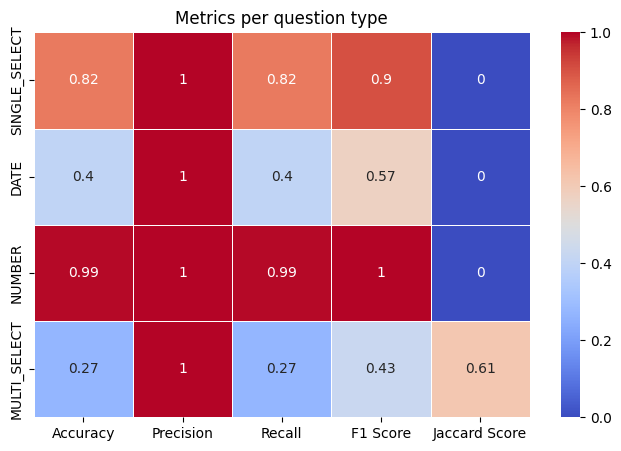

In [9]:
print("Overall metrics:")
for key, value in overall.items():
    print(f"{key}: {value:.4f}")
print()

plot_metrics(metrics1, overall)

### QA pipeline 2, without Regex

In [10]:
metrics2, overall = predict_answers(data, qa_pipeline2)

Extracted time: tomorrow, predicted date: 2025-01-10, intended date: 2025-01-10
Extracted time: Tuesday, predicted date: 2025-01-14, intended date: 2025-01-16
Extracted time: about three weeks, predicted date: 2025-01-30, intended date: 2025-01-30
DATE question processing failed: Unable to parse date from extracted time: like a months time
DATE question processing failed: Unable to parse date from extracted time: mid July
Extracted time: tomorrow, predicted date: 2025-01-29, intended date: 2025-01-29
DATE question processing failed: Unable to parse date from extracted time: middle of next week
Extracted time: two weeks, predicted date: 2025-02-11, intended date: 2025-02-11
Extracted time: three weeks, predicted date: 2025-02-18, intended date: 2025-02-18
DATE question processing failed: Unable to parse date from extracted time: sometime next month
DATE question processing failed: Unable to parse date from extracted time: tomorrow afternoon
DATE question processing failed: unsupported o

Overall metrics:
Accuracy: 0.6173
Precision: 1.0000
Recall: 0.6173
F1 Score: 0.7634
Jaccard Score: 0.0000



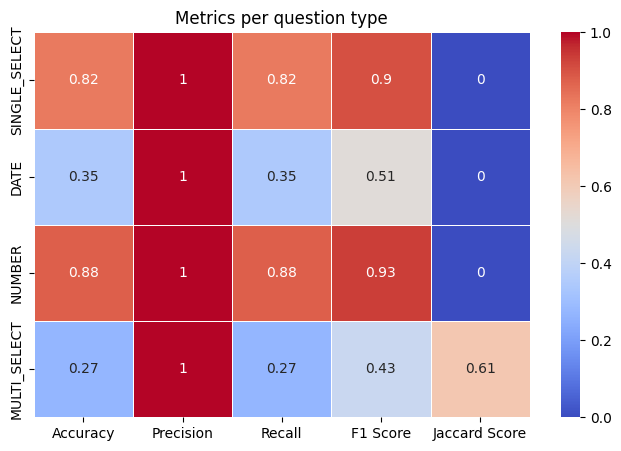

In [11]:
print("Overall metrics:")
for key, value in overall.items():
    print(f"{key}: {value:.4f}")
print()

plot_metrics(metrics2, overall)

### QA pipeline 3, without Regex

In [12]:
metrics3, overall = predict_answers(data, qa_pipeline3)

DATE question processing failed: Unable to parse date from extracted time: sometime tomorrow
DATE question processing failed: Unable to parse date from extracted time: sometime next week
Extracted time: three weeks, predicted date: 2025-01-30, intended date: 2025-01-30
DATE question processing failed: Unable to parse date from extracted time: months time
DATE question processing failed: Unable to parse date from extracted time: mid July
Extracted time: tomorrow, predicted date: 2025-01-29, intended date: 2025-01-29
DATE question processing failed: Unable to parse date from extracted time: middle of next week
Extracted time: two weeks, predicted date: 2025-02-11, intended date: 2025-02-11
DATE question processing failed: Unable to parse date from extracted time: three weeks from now
Extracted time: next month, predicted date: 2025-02-28, intended date: 2025-02-28
DATE question processing failed: Unable to parse date from extracted time: tomorrow afternoon
DATE question processing failed

Overall metrics:
Accuracy: 0.6188
Precision: 1.0000
Recall: 0.6188
F1 Score: 0.7645
Jaccard Score: 0.0000



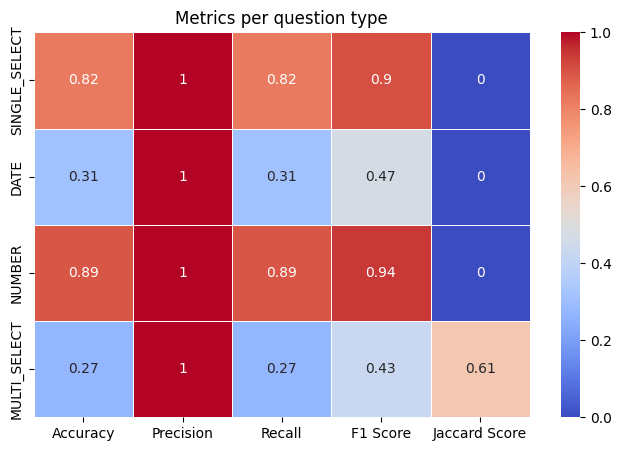

In [13]:
print("Overall metrics:")
for key, value in overall.items():
    print(f"{key}: {value:.4f}")
print()

plot_metrics(metrics3, overall)

### QA pipeline 1, WITH Regex

In [14]:
metrics1r, overall = predict_answers_regex(data, qa_pipeline1)

Extracted time: tomorrow, predicted date: 2025-01-10, intended date: 2025-01-10
Extracted time: next week, predicted date: 2025-01-16, intended date: 2025-01-16
Extracted time: three weeks, predicted date: 2025-01-30, intended date: 2025-01-30
DATE question processing failed: Unable to parse date from extracted time: a months time
DATE question processing failed: Unable to parse date from extracted time: mid July
Extracted time: tomorrow, predicted date: 2025-01-29, intended date: 2025-01-29
DATE question processing failed: Unable to parse date from extracted time: middle of next week
Extracted time: two weeks, predicted date: 2025-02-11, intended date: 2025-02-11
Extracted time: three weeks, predicted date: 2025-02-18, intended date: 2025-02-18
Extracted time: next month, predicted date: 2025-02-28, intended date: 2025-02-28
DATE question processing failed: Unable to parse date from extracted time: tomorrow afternoon
DATE question processing failed: unsupported operand type(s) for -: 

Overall metrics:
Accuracy: 0.8068
Precision: 1.0000
Recall: 0.8068
F1 Score: 0.8931
Jaccard Score: 0.0000



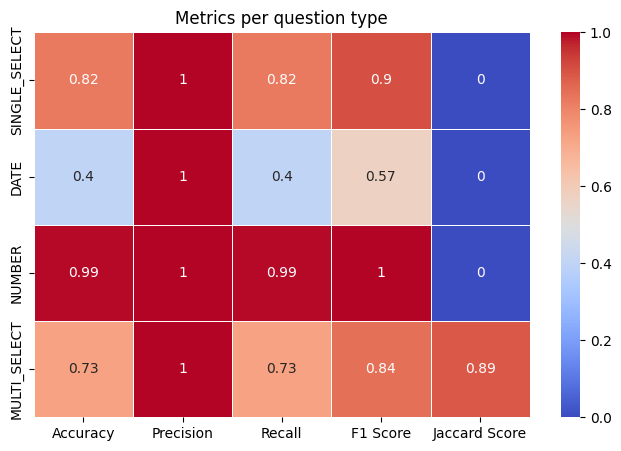

In [15]:
print("Overall metrics:")
for key, value in overall.items():
    print(f"{key}: {value:.4f}")
print()

plot_metrics(metrics1r, overall)

**Results:**
The three QA pipelines yield very similar results. They all have an accuracy around 60%. The first pipeline is slightly better than the others. Through several tests, we found out that the bad accuracy resulst from the bad prediction of multi select questions. If we introduce an additional regex check for multi select questions, we achieve an accuracy of >80%.


### Heatmap Comparison

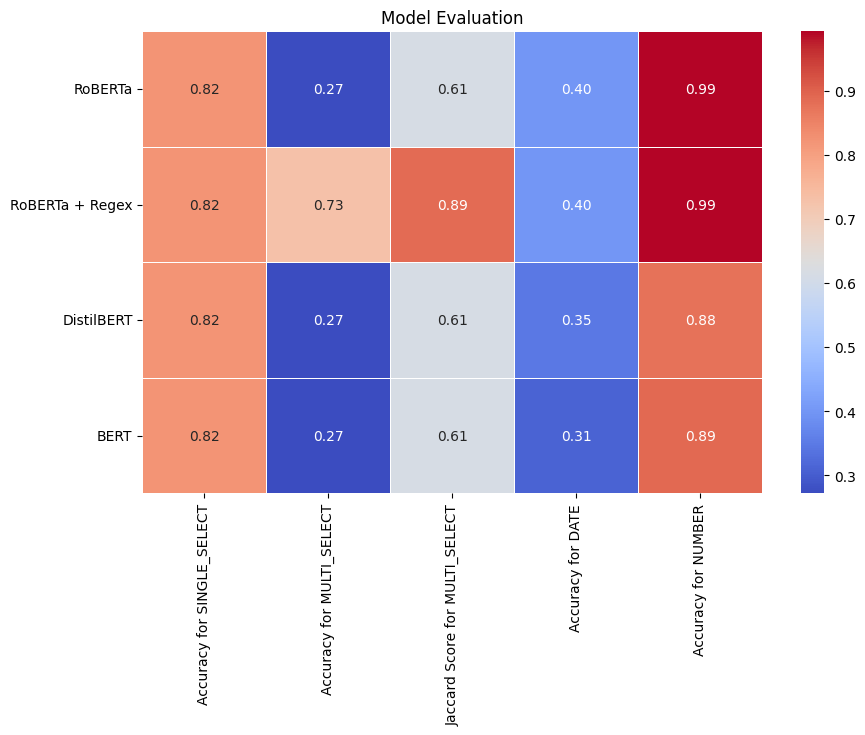

In [30]:
models = ["RoBERTa", "RoBERTa + Regex", "DistilBERT", "BERT"]

selected_metrics = {
    "SINGLE_SELECT": ["Accuracy"],
    "MULTI_SELECT": ["Accuracy", "Jaccard Score"],
    "DATE": ["Accuracy"],
    "NUMBER": ["Accuracy"],
}

df = []
for metrics in [metrics1, metrics1r, metrics2, metrics3]:
    row = []

    for category, metrics_list in selected_metrics.items():
        for metric in metrics_list:
            row.append(metrics[category].get(metric, 0))

    df.append(row)

columns = [f"{metric} for {category}" for category, metrics_list in selected_metrics.items() for metric in metrics_list]
df = pd.DataFrame(df, index=models, columns=columns)
plt.figure(figsize=(10, 6))
ax = sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Model Evaluation")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right")

plt.show()

### Tests for Multi-Select
As the qa models perform really bad on multi-select questions, we wanted to get some deeper insights into the evaluation.

In [31]:
def predict_MS_answers(df, qa_pipeline):
    correct_count = 0
    total_count = 0

    for _, row in df.iterrows():
        predictions = list()
        is_correct = False
        y_true = []  # list for correct values
        y_pred = []  # list for predicted values

        if (row['type'] == "MULTI_SELECT"):
            results = qa_pipeline(question=row['question'], context=row['context'])
            print(f"Pipeline results: {results}")

            if isinstance(results, dict):
                results = [results]
            elif not isinstance(results, list):
                print(f"Warning: Unexpected output format from qa_pipeline for question: {row['question']}")
                continue

            for result in results:
                extracted_answer = result.get('answer', '')
                for option in row['options']:
                    similarity_score = fuzz.ratio(extracted_answer.lower(), option.lower())
                    print(f"Checking similarity: '{extracted_answer}' vs '{option}' → Score: {similarity_score}")
                    if similarity_score >= 50:
                        predictions.append((option, result.get('score', 0)))

            if predictions:
                predicted_option = []
                for option, score in predictions:
                    if option not in predicted_option:
                        predicted_option.append(option)
                is_correct = set(predicted_option) == set(row['intended_answer'])
            else:
                print(f"No predictions found for MULTI_SELECT: {row['question']}")
                predicted_option = None

            y_true.append(1 if row['intended_answer'] else 0)
            y_pred.append(1 if is_correct else 0)

        # Ignore all other question types
        else:
          continue;

        if is_correct:
            correct_count += 1
        total_count += 1

In [32]:
multi_select_data = data[data['type'] == 'MULTI_SELECT']
first_20_MS = multi_select_data.head(20)

predict_MS_answers(first_20_MS, qa_pipeline_ms)

Pipeline results: [{'score': 0.10768845677375793, 'start': 60, 'end': 94, 'answer': 'MY-SYSTEM for general productivity'}, {'score': 0.09010032564401627, 'start': 56, 'end': 94, 'answer': 'the MY-SYSTEM for general productivity'}, {'score': 0.07837676256895065, 'start': 60, 'end': 69, 'answer': 'MY-SYSTEM'}, {'score': 0.06557594239711761, 'start': 56, 'end': 69, 'answer': 'the MY-SYSTEM'}, {'score': 0.025532925501465797, 'start': 60, 'end': 125, 'answer': "MY-SYSTEM for general productivity, then of course there's Notion"}, {'score': 0.008520758710801601, 'start': 51, 'end': 94, 'answer': 'like the MY-SYSTEM for general productivity'}, {'score': 0.007675222121179104, 'start': 60, 'end': 95, 'answer': 'MY-SYSTEM for general productivity,'}, {'score': 0.0065266406163573265, 'start': 74, 'end': 94, 'answer': 'general productivity'}, {'score': 0.006421672645956278, 'start': 56, 'end': 95, 'answer': 'the MY-SYSTEM for general productivity,'}, {'score': 0.006201496347784996, 'start': 51, 'en

## Fine-tune QA Model

*   We fine-tuned our best performing model (deepset/roberta-base-squad2) on our own data with the Huggingface Trainer API and the corresponding AutoTokeniizer
*   Problem: Intended answer serves as label
    *   QA model can only be trained with data, where the intended answer appears in exactly the same way in the context --> Some entries are not suitable for training
    *   We used multi select questions for training, but QA models are actually not meant to extract multiple answers
    *   Date and text questions are not suitable for training, because they don't have appropriate labels
    *   Lack of appropriate data leads to a bad model

In [19]:
!pip install rapidfuzz
from rapidfuzz import process, fuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.7 MB/s eta 0:00:00


In [33]:
# Prepare dataset in required format
def prepare_squad_data(df):
    squad_data = {"data": []}

    for idx, row in df.iterrows():
        question = row["question"]
        context = row["context"]
        intended_answer = row["intended_answer"]
        if row['type'] == 'TEXT':
          continue

        start_positions = []
        end_positions = []
        found_answers = []

        if isinstance(intended_answer, list):
            possible_answers = intended_answer
        else:
            possible_answers = [intended_answer]

        # Fuzzy search for each intended answer
        for answer in possible_answers:
            answer = str(answer)
            match = process.extractOne(answer, context.split(), scorer=fuzz.partial_ratio, score_cutoff=70)

            if match:
                best_match_text = match[0]
                start = context.find(best_match_text)
                if start != -1:
                    start_positions.append(start)
                    end_positions.append(start + len(best_match_text))
                    found_answers.append(best_match_text)

        if not found_answers:
            continue  # Skip if no answer was found

        squad_data["data"].append({
            "paragraphs": [
                {
                    "context": context,
                    "qas": [
                        {
                            "question": question,
                            "id": f"q_{idx}",
                            "answers": [
                                {"text": ans, "answer_start": start} for ans, start in zip(found_answers, start_positions)
                            ],
                            "is_impossible": False
                        }
                    ]
                }
            ]
        })

    return squad_data

def tokenize_squad_data(squad_data, tokenizer, max_length=512):
    """
    Tokenizes the prepared SQuAD-Dataset with robust answer searching.
    """
    phone_regex = re.compile(r"\+?\d{1,3}[-\s]?\(?\d{1,4}\)?[-\s]?\d{1,4}[-\s]?\d{1,9}")
    tokenized_examples = []

    for data in squad_data["data"]:
        for paragraph in data["paragraphs"]:
            context = paragraph["context"]

            # Mark phone numbers in context
            context_matches = phone_regex.findall(context)
            for match in context_matches:
                context = context.replace(match, f"[PHONE_TOKEN_{match}]")

            for qa in paragraph["qas"]:
                question = qa["question"]
                answers = qa["answers"]

                # Preprocess answers: mark phone numbers
                processed_answers = []
                for answer in answers:
                    answer_text = answer["text"]
                    if phone_regex.match(answer_text):
                        answer_text = f"[PHONE_TOKEN_{answer_text}]"
                    processed_answers.append({
                        "text": answer_text,
                        "answer_start": context.find(answer_text)  # New start position
                    })

                # Extract positions of answers
                start_positions = [answer["answer_start"] for answer in processed_answers]
                answer_texts = [answer["text"] for answer in processed_answers]

                # Tokenize questions and context
                tokenized_example = tokenizer(
                    question,
                    context,
                    max_length=max_length,
                    truncation="only_second",  # Cut off context if too long
                    padding="max_length",
                    return_offsets_mapping=True
                )

                # Normalize context and answers for case-insensitive matching
                token_start_positions = []
                token_end_positions = []
                context_lower = context.lower()
                answer_texts_lower = [answer.lower() for answer in answer_texts]

                for answer_text, answer_text_lower in zip(answer_texts, answer_texts_lower):
                    start_position = context_lower.find(answer_text_lower)

                    # Fallback: Try fuzzy matching if exact match fails
                    if start_position == -1:
                        match = process.extractOne(answer_text_lower, context_lower.split(), scorer=fuzz.partial_ratio, score_cutoff=70)
                        if match:
                            best_match_text = match[0]
                            start_position = context_lower.find(best_match_text)

                    if start_position != -1:
                        token_start_positions.append(start_position)
                        token_end_positions.append(start_position + len(answer_text))
                    else:
                        print(f"Warning: Answer '{answer_text}' not found in context for question: {question}")

                # Save tokenized data
                tokenized_example["start_positions"] = token_start_positions[0] if token_start_positions else 0
                tokenized_example["end_positions"] = token_end_positions[0] if token_end_positions else 0
                tokenized_examples.append(tokenized_example)

    return tokenized_examples


In [34]:
# Split into training and test data (test data is not processed)
train_data, test_data = train_test_split(data, test_size=0.3, stratify=data["type"], random_state=42)

# Prepare training and evaluation data
squad_data = prepare_squad_data(train_data)

tokenizer = AutoTokenizer.from_pretrained("deepset/roberta-base-squad2")
tokenized_data = tokenize_squad_data(squad_data, tokenizer)

train_data, val_data = train_test_split(tokenized_data, test_size=0.3, random_state=42)

# Dataset Class for Huggingface
class SquadDataset:
    def __init__(self, data):
        self.data = Dataset.from_dict({k: [v] for k, v in data[0].items()})
        for item in data[1:]:
            self.data = self.data.add_item(item)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            "input_ids": item["input_ids"],
            "attention_mask": item["attention_mask"],
            "start_positions": item["start_positions"],
            "end_positions": item["end_positions"]
        }

# Create Huggingface Datasets
train_dataset = SquadDataset(train_data)
val_dataset = SquadDataset(val_data)
print(len(train_dataset))

636


In [22]:
# Load model
model = AutoModelForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2")

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_ratio=0.06,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=1000,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    report_to="none"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-22-07e6a31c7ea7>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [23]:
# Start training
trainer.train()

Epoch,Training Loss,Validation Loss
1,5.926100,5.896022
2,5.782700,5.855764
3,5.804000,5.839323
4,5.659900,5.847250
5,5.475500,5.861461


TrainOutput(global_step=200, training_loss=5.961399402618408, metrics={'train_runtime': 516.0976, 'train_samples_per_second': 6.162, 'train_steps_per_second': 0.388, 'total_flos': 830923686420480.0, 'train_loss': 5.961399402618408, 'epoch': 5.0})

In [36]:
# Save model in google drive

from google.colab import drive

try:
    drive.mount('/content/drive', force_remount=True)
except ValueError as e:
    if "already mounted" in str(e):
        print("Drive already mounted at /content/drive")
    else:
        raise e

!cp -r ./results /content/drive/MyDrive

Mounted at /content/drive


In [37]:
# Load model and create pipeline
import os

results_path = '/content/drive/MyDrive/results'
folders = [os.path.join(results_path, folder) for folder in os.listdir(results_path) if os.path.isdir(os.path.join(results_path, folder))]
latest_folder = max(folders, key=os.path.getctime)

model_path = latest_folder

model = AutoModelForQuestionAnswering.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

qa_pipeline_finetuned = pipeline("question-answering", model=model, tokenizer=tokenizer)

In [38]:
metrics, overall = predict_answers(data, qa_pipeline_finetuned)

DATE question processing failed: Unable to parse date from extracted time: well, I think
DATE question processing failed: Unable to parse date from extracted time: , how about we schedule another check-in sometime next week,
DATE question processing failed: Unable to parse date from extracted time: could
DATE question processing failed: Unable to parse date from extracted time: Lets
DATE question processing failed: Unable to parse date from extracted time: something like mid July
Extracted time: I, predicted date: 2026-01-28, intended date: 2025-01-29
DATE question processing failed: Unable to parse date from extracted time: if
DATE question processing failed: Unable to parse date from extracted time: Based on
DATE question processing failed: Unable to parse date from extracted time: accounting
DATE question processing failed: Unable to parse date from extracted time: Looking
DATE question processing failed: Unable to parse date from extracted time: based
DATE question processing faile

Overall metrics:
Accuracy: 0.4940
Precision: 1.0000
Recall: 0.4940
F1 Score: 0.6613
Jaccard Score: 0.0000



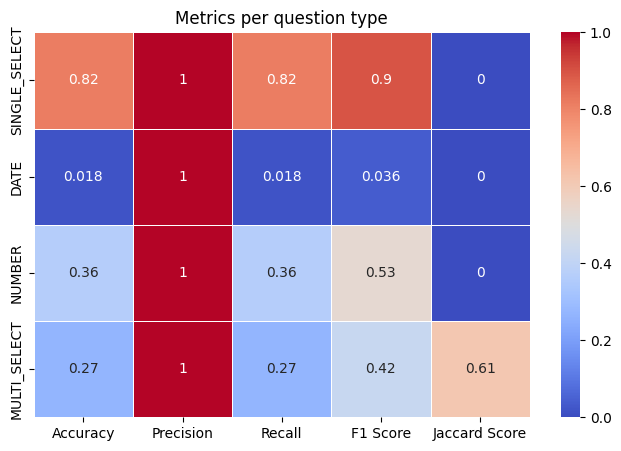

In [39]:
print("Overall metrics:")
for key, value in overall.items():
    print(f"{key}: {value:.4f}")
print()

plot_metrics(metrics, overall)